<a href="https://colab.research.google.com/github/SiciliaLeco/EyeGaze/blob/master/Normalized_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appearance-based Gaze Estimation (Feb 20)

dataset: MPIIGaze https://www.perceptualui.org/research/datasets/MPIIGaze/ 

CNN frame: LeNet 

### 1. Pre-processing data 

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from PIL import Image
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import drive 

To use COLAB, we should first connect to the drive then retreive the data.

In [ ]:
# Use google.colab to use drive dataset  
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/EyeGaze"
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Normalized', 'Untitled0.ipynb']

In [ ]:
mat_files = glob.glob(path + '/Normalized/**/*.mat', recursive=True)
mat_files.sort()
print(mat_files)

['/content/drive/MyDrive/EyeGaze/Normalized/p00/day01.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day02.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day03.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day04.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day05.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day06.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day07.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day08.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day09.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day10.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day11.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day12.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day13.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day14.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day15.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day16.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day17.ma

In [ ]:
from scipy.io import loadmat
def read_eye_data(mat):
  '''
  read each mat file info 
  '''
  mat_data = loadmat(mat)
  right_info = mat_data['data']['right'][0, 0]
  gaze = right_info['gaze'][0, 0]
  image = right_info['image'][0, 0]
  pose = right_info['pose'][0, 0]
  return gaze, image, pose

def collect_data_from_mat(path):
  '''
  collect data from annotation part
  :param path: path of normalized data 
  :return:  list of index, image, pose, gaze
  '''
  mat_files = glob.glob(path + '/Normalized/**/*.mat', recursive = True)
  mat_files.sort()
  # dict to store
  gaze = list()
  image = list()
  index = list()
  pose = list()
  # X: image, head_pose 
  # y: gaze vector
  # index: pnum, pday
  for matfile in tqdm(mat_files):
    pnum = matfile.split('/')[-2]  # pxx
    pday = matfile.split('/')[-1].split('.')[0] # day0x
    index.append(pnum + '/' + pday)
    
    fgaze, fimage, fpose = read_eye_data(matfile)

    if gaze == []:
      gaze = fgaze
      image = fimage
      pose = fpose
    else:
      gaze = np.append(gaze, fgaze, axis = 0)
      image = np.append(image, fimage, axis = 0)
      pose = np.append(pose, fpose, axis = 0)

  return gaze, image, pose, index 

100%|██████████| 521/521 [00:34<00:00, 14.99it/s]


In [ ]:
gaze, image, pose, index = collect_data_from_mat(path)

In [ ]:
print("gaze vector shape")
print(gaze.shape)
print("pose vector shape")
print(pose.shape)
print("image vector shape")
print(image.shape)

gaze vector shape
(213658, 3)
pose vector shape
(213658, 3)
image vector shape
(213658, 36, 60)


From the above data processing, we can know the dimension and size of the vector.
Now the gaze vector and pose vector are all 3 dimension, while the eye image (we only process one eye in this training task) is a 36 * 60 pixels grey image.
I'll print an example of the data:

p00/day01
[-0.15190792  0.24172508  0.01848624]
[-0.12202543  0.09011014 -0.98842802]


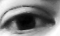

In [ ]:
idx = 0
print(index[idx])
print(pose[idx])
print(gaze[idx])
Image.fromarray(image[idx].reshape((36, 60)))

### 2. Dimension transformation
In this part, we should change pose and gaze vector from 3D to 2D. The suggested code is shown on the dataset website.

In [ ]:
def pose3D_to_2D(pose):
  '''
    pose (a, b, c) is rotation (angle)
  '''

  #TODO: transform 3D to 2D
  pass

def gaze3D_to_2D(gaze):
  '''
    gaze (x, y, z) is direction
  '''
  #TODO: transform 3D to 2D
  pass

def gaze3Dto2D(array, stack=True):
    """
    theta = asin(-y)
    phi = atan2(-x, -z)
    """
    if array.ndim == 2:
        assert array.shape[1] == 3
        x, y, z = (array[:, i]for i in range(3))
    elif array.ndim == 1:
        assert array.shape[0] == 3
        x, y, z = (array[i] for i in range(3))
        
    theta = np.arcsin(-y)
    phi = np.arctan2(-x, -z)
    
    if not stack:
        return theta, phi
    elif stack:
        return np.stack((theta, phi)).T

def pose3Dto2D(array):
    """
    M = Rodrigues((x,y,z))
    Zv = (the third column of M) ???
    theta = asin(Zv[1])
    phi = atan2(Zv[0], Zv[2])
    """
    def convert_pose(vect):
        M, _ = Rodrigues(np.array(vect).astype(np.float32))
        Zv = M[:, 2]
        theta = np.arctan2(Zv[0], Zv[2])
        phi = np.arcsin(Zv[1])
        return np.array([theta, phi])
    
    return np.apply_along_axis(convert_pose, 1, array)


### 3. Muti-modal CNN

Use the LeNet framework.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(torch.nn.Module):

    def __init__(self):
        # image input: 36, 60, 1
        # pose input: 2,
        # conv1: 20, (5,5)
        # pool2: (2,2)
        # conv3: 50, (5,5)
        # pool4: (2,2)
        # full5:
        # concat: ?
        # output:

        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fuco1 = torch.nn.Linear(50*12*24, 500 - 2) # Not sure if it's correct
        
    def forward(self, x, x1):
        #TODO: forward output
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = self.fuco1(out)
        out = torch.cat((out, x1), 0)
        return out


### References
1. https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/appearance-based-gaze-estimation-in-the-wild

